# Data Preparation for Sentiment Analysis of the Three Constituencies (Sengkang, Hougang and Aljunied) Won by the Workers’ Party in 2020 GE

### Table of Content

[0. Text Cleaning/Processing Functions](#text_clean_process) <br>

[1. Pre-processing training dataset sentiment140_for_training.csv](#train_data_preprocess) <br>

[2. Pre-processing scraped tweets pertaining to Sengkang, Hougang, Aljunied Constituencies](#sengkang_hougang_aljunied) <br>



In [2]:
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
from argparse import Namespace

### <a id='train_data_preprocess'></a> 1. Pre-processing training dataset sentiment140_for_training.csv

In [4]:
args = Namespace(                               
    raw_train_dataset_csv="data/twitter/sentiment140_for_training.csv",
    train_proportion=0.7,
    val_proportion=0.15,
    test_proportion=0.15,
    output_munged_csv="data/twitter/sentiment140_tweets_with_splits.csv",
    #output_munged_csv="data/twitter/sentiment140_tweets_with_splits_lite.csv", #debug purpose
    seed=1337
)

In [6]:
train_tweets = pd.read_csv(args.raw_train_dataset_csv, encoding = "ISO-8859-1")
train_tweets.columns=['polarity','tweetid','date','nq','author','tweet']

#debug purpose, randomly drop some data, as original file is too big (1.6 million tweets)
#row_to_drop = 1589999
#drop_indices = np.random.choice(train_tweets.index, row_to_drop, replace=False)
#train_tweets = train_tweets.drop(drop_indices)

train_tweets

,polarity,tweetid,date,nq,author,tweet
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [7]:
train_tweets = train_tweets.drop(["tweetid","date","nq","author"],axis=1) #only polarity and tweet content
train_tweets

,polarity,tweet
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew
...,...,...
1599994,4,Just woke up. Having no school is the best fee...
1599995,4,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,Happy 38th Birthday to my boo of alll time!!! ...


In [8]:
train_tweets.rename(columns={'polarity':'sentiment'}, inplace=True)
train_tweets['sentiment'] = train_tweets.sentiment.apply({0: 'negative', 4: 'positive'}.get)
train_tweets

,sentiment,tweet
0,negative,is upset that he can't update his Facebook by ...
1,negative,@Kenichan I dived many times for the ball. Man...
2,negative,my whole body feels itchy and like its on fire
3,negative,"@nationwideclass no, it's not behaving at all...."
4,negative,@Kwesidei not the whole crew
...,...,...
1599994,positive,Just woke up. Having no school is the best fee...
1599995,positive,TheWDB.com - Very cool to hear old Walt interv...
1599996,positive,Are you ready for your MoJo Makeover? Ask me f...
1599997,positive,Happy 38th Birthday to my boo of alll time!!! ...


In [14]:
start_time = time.time()
by_sentiment = collections.defaultdict(list)
for _, row in tqdm(train_tweets.iterrows()):
    by_sentiment[row.sentiment].append(row.to_dict())

end_time = time.time()
print("Time taken to create by_sentiment: " , round(end_time - start_time,3),"seconds") # 3.5mins

#print(by_sentiment)
# by_sentiment will be like below:
#  {
#   'negative' : [{'sentiment': 'negative', 'tweet': 'bad weather ...'}, ], 
#   'positive' : [{'sentiment': 'positive', 'tweet': 'good hoodie ...'}, ]
#  }


Time taken to create by_sentiment:  218.708 seconds


sentiment contains:  {'positive', 'negative'} 

positive    800000
negative    799999
Name: sentiment, dtype: int64 



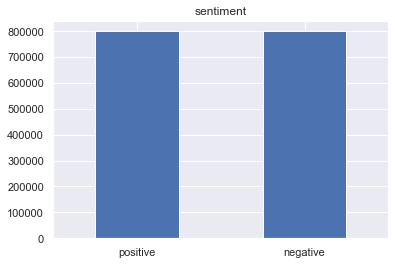

In [15]:
# Unique labels of sentiment
print("sentiment contains: ", set(train_tweets.sentiment), "\n")
print(train_tweets.sentiment.value_counts() , "\n")
train_tweets.sentiment.value_counts().plot(kind="bar",subplots="True")
sns.set()
plt.xticks(rotation=0)
plt.show()

In [16]:
final_list = []
np.random.seed(args.seed)

for _, item_list in tqdm(sorted(by_sentiment.items())): #tuple ('negative', [ {}, {}])

    np.random.shuffle(item_list)
    
    n_total = len(item_list)
    n_train = int(args.train_proportion * n_total) #70%
    n_val = int(args.val_proportion * n_total)     #15%
    n_test =  n_total - n_train - n_val            #15%
    
    print(_, "n_total:", n_total, "n_train:", n_train, "n_val:", n_val, "n_test:", n_test)
    
    # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train' #new split col, label as train
    
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'
        
    for item in item_list[n_train+n_val:n_train+n_val+n_test]:
        item['split'] = 'test'

    # Add to final list
    final_list.extend(item_list) # use extend when adding multiple elements to a list; use append for additing one element.
        

negative n_total: 799999 n_train: 559999 n_val: 119999 n_test: 120001
positive n_total: 800000 n_train: 560000 n_val: 120000 n_test: 120000



In [17]:
final_train_tweets = pd.DataFrame(final_list)
final_train_tweets

,sentiment,tweet,split
0,negative,I dont want Jon and Kate to seperate!,train
1,negative,"@spamboy true, but I still think having the ID...",train
2,negative,My legs are sooo sore I hope I can sleep the ...,train
3,negative,Somebody save me! I don't want to be sick,train
4,negative,@Mimiteh26 I have this odd feeling in my back....,train
...,...,...,...
1599994,positive,@MsArtOfSoul I'm not the one being petty,test
1599995,positive,@AyeBloodyRight Yes Am going to Spain - can't...,test
1599996,positive,@z3bbster @Ruth_Z: My Official Stats:my closes...,test
1599997,positive,"watching high school musical 3, then reading i...",test


train    1119999
test      240001
val       239999
Name: split, dtype: int64


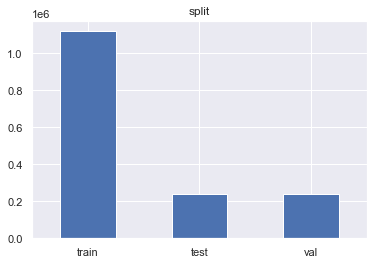

In [18]:
print(final_train_tweets.split.value_counts())

final_train_tweets.split.value_counts().plot(kind="bar",subplots="True")
sns.set()
plt.xticks(rotation=0)
plt.show()

###  0. <a id='text_clean_process'></a> Text Cleaning/Processing Functions

In [19]:
stop_words = set(stopwords.words('english'))
stop_words.remove("not")

def text_clean(s):
    bad_chars_lst = [';', ':', '!', '*', '(' , ')', '&','[',']','.','?','{','}',',']
    text = "".join(i for i in s if ord(i)< 128) #join ASCII
    
    html_decoded_string = BeautifulSoup(text, "lxml")
    deco_string = html_decoded_string.string#replace HTML escape characters with actual ones. e.g., &quot; to "
    
    text_no_name = " ".join((filter(lambda x:x[0]!='@', deco_string.split()))) #remove @names e.g., @wangzhiyuan
    text_no_badchars = ''.join(filter(lambda i: i not in bad_chars_lst, text_no_name))#remove bad chars
    text_no_links = re.sub(r"http\S+", "", text_no_badchars)#greedy removal http...
    text_no_websites = re.sub(r"www.[^ ]+","",text_no_links)#greedy removal www...
    text_no_numbers = re.sub(r"[0-9]+","",text_no_websites)#replace number with empty 
    stemmed_text = words_process(text_no_numbers)
    clean_text = decontracted(stemmed_text)
    
    return clean_text

def words_process(text): 
    words = word_tokenize(text) 
    words = stopword_removal(words)
    words = stem_word(words)
    result = ""
    for word in words:
        result += word + " "
    return result

def stopword_removal(words):
    result = []
    for word in words:
        if word not in stop_words:
            result.append(word)
    return result

def stem_word(words):
    port = PorterStemmer() #stem
    #snow = SnowballStemmer("english")
    #lema = WordNetLemmatizer()
    result = []
    for word in words:
        word = word.lower()
        stem = port.stem(word)
        #stem = lema.lemmatize(word)
        result.append(stem)
    return result

def decontracted(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


In [24]:
#print(final_train_tweets.head())
start_time = time.time()
tweets = final_train_tweets.tweet
print("Cleaning Tweets: ")
tweets = [text_clean(t) for t in tqdm(tweets)]
final_train_tweets.tweet = tweets
end_time = time.time()
print("Time taken to clean tweets: " , round(end_time - start_time,3),"seconds") # roughly need 20 mins
#print(final_train_tweets.head())

Cleaning Tweets: 



Time taken to clean tweets:  1372.05 seconds


In [25]:
final_train_tweets.to_csv(args.output_munged_csv, index=False, header=True) #save header, but not row index
final_train_tweets = pd.read_csv(args.output_munged_csv, encoding = "ISO-8859-1")

print("Before removal: {} missing values in final_train_tweets dataframe".format(final_train_tweets.isnull().sum().sum()))
# Remove null from train data
final_train_tweets = final_train_tweets.dropna()
print("After removal:  {} missing values in final_train_tweets frame".format(final_train_tweets.isnull().sum().sum()))

final_train_tweets.to_csv(args.output_munged_csv, index=False, header=True) #save header, but not row index

Before removal: 5680 missing values in final_train_tweets dataframe
After removal:  0 missing values in final_train_tweets frame


In [26]:
final_train_tweets = pd.read_csv(args.output_munged_csv, encoding = "ISO-8859-1") #after the above text cleaning step
final_train_tweets

,sentiment,tweet,split
0,negative,i dont want jon kate seper,train
1,negative,true i still think id screen option see would ...,train
2,negative,my leg sooo sore i hope i sleep sore awaynow i...,train
3,negative,somebodi save i not want sick,train
4,negative,i odd feel back it is like `` time month '' c...,train
...,...,...,...
1594314,positive,i am not one petti,test
1594315,positive,ye am go spain - ca not wait,test
1594316,positive,my offici statsmi closest friend < - nr,test
1594317,positive,watch high school music read bed,test


negative    797226
positive    797093
Name: sentiment, dtype: int64 



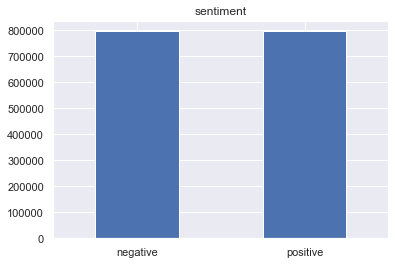

train    1116018
val       239174
test      239127
Name: split, dtype: int64


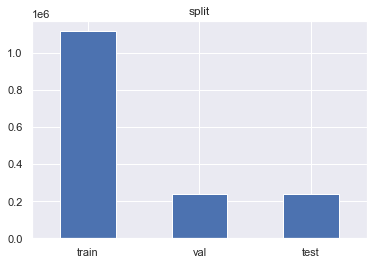

In [27]:
print(final_train_tweets.sentiment.value_counts(), "\n")
final_train_tweets.sentiment.value_counts().plot(kind="bar",subplots="True")
sns.set()
plt.xticks(rotation=0)
plt.show()

print(final_train_tweets.split.value_counts())
final_train_tweets.split.value_counts().plot(kind="bar",subplots="True")
sns.set()
plt.xticks(rotation=0)
plt.show()

## <a id='sengkang_hougang_aljunied'></a> 2. Pre-processing scraped tweets pertaining to Sengkang, Hougang, Aljunied Constituencies

### Load scraped twitter files, drop unused columns and remove duplicated rows

In [41]:
#For Sengkang

sengkang_tweets0907 = pd.read_csv("data/twitter/sengkang09-07.csv", encoding = "ISO-8859-1")
sengkang_tweets0907.columns=['index','user','tweet','date_tweet','tweet_id','keyword']
sengkang_tweets0922 = pd.read_csv("data/twitter/sengkang09-22.csv", encoding = "ISO-8859-1")
sengkang_tweets0922.columns=['index','user','tweet','date_tweet','tweet_id','keyword']
sengkang_tweets0923 = pd.read_csv("data/twitter/sengkang09-23.csv", encoding = "ISO-8859-1")
sengkang_tweets0923.columns=['index','user','tweet','date_tweet','tweet_id','keyword']
sengkang_tweets0924 = pd.read_csv("data/twitter/sengkang09-24.csv", encoding = "ISO-8859-1")
sengkang_tweets0924.columns=['index','user','tweet','date_tweet','tweet_id','keyword']
sengkang_tweets1004 = pd.read_csv("data/twitter/sengkang10-04.csv", encoding = "ISO-8859-1")
sengkang_tweets1004.columns=['index','user','tweet','date_tweet','tweet_id','keyword']
sengkang_tweets1013 = pd.read_csv("data/twitter/sengkang10-13.csv", encoding = "ISO-8859-1")
sengkang_tweets1013.columns=['index','user','tweet','date_tweet','tweet_id','keyword']
sengkang_tweets1018 = pd.read_csv("data/twitter/sengkang10-18.csv", encoding = "ISO-8859-1")
sengkang_tweets1018.columns=['index','user','tweet','date_tweet','tweet_id','keyword']
sengkang_tweets1023 = pd.read_csv("data/twitter/sengkang10-23.csv", encoding = "ISO-8859-1")
sengkang_tweets1023.columns=['index','user','tweet','date_tweet','tweet_id','keyword']

sengkang_tweets = pd.concat([sengkang_tweets0907, sengkang_tweets0922, sengkang_tweets0923,
                             sengkang_tweets0924, sengkang_tweets1004, sengkang_tweets1013,
                             sengkang_tweets1018, sengkang_tweets1023], 
                             ignore_index=True, sort=False)

sengkang_tweets = sengkang_tweets.drop(['index','user','tweet_id','keyword'],axis=1) #only tweet and date
print('before remvoing duplicates', sengkang_tweets.shape)
sengkang_tweets = sengkang_tweets.drop_duplicates() #drop duplicates
print('after remvoing duplicates', sengkang_tweets.shape)
print('sengkang_tweets\n', sengkang_tweets, '\n\n')

before remvoing duplicates (712, 2)
after remvoing duplicates (472, 2)
sengkang_tweets
                                                  tweet           date_tweet
0    When the GE poll results of Sengkang GRC were ...  2020-09-06 19:58:32
1    can punggol people please be normal and do wha...  2020-09-06 14:42:13
2    Former MP Who Lost in Sengkang GRC Had Thought...  2020-09-06 12:57:33
3    me me after i settle things at sengkang !! htt...  2020-09-06 12:42:16
4    Few shots from my morning run today. From Seng...  2020-09-06 11:01:26
..                                                 ...                  ...
680      Why tf is Boon Lay so far from Seng Kang? Ugh  2020-10-18 17:02:39
681  @bbhdiet i have so many friends living in seng...  2020-10-18 11:08:12
682  @AudiKhalid @mediumshawn Itâs clearly becaus...  2020-10-18 09:58:10
683                i hate everyone staying at sengkang  2020-10-18 08:02:02
684  @acid_twt REALLY?????? omg maybe iâll sudden...  2020-10-18 07:20:34


In [42]:
#For Hougang

hougang_tweets0922 = pd.read_csv("data/twitter/hougang09-22.csv", encoding = "ISO-8859-1")
hougang_tweets0922.columns=['index','user','tweet','date_tweet','tweet_id','keyword']
hougang_tweets0923 = pd.read_csv("data/twitter/hougang09-23.csv", encoding = "ISO-8859-1")
hougang_tweets0923.columns=['index','user','tweet','date_tweet','tweet_id','keyword']
hougang_tweets0924 = pd.read_csv("data/twitter/hougang09-24.csv", encoding = "ISO-8859-1")
hougang_tweets0924.columns=['index','user','tweet','date_tweet','tweet_id','keyword']
hougang_tweets1004 = pd.read_csv("data/twitter/hougang10-04.csv", encoding = "ISO-8859-1")
hougang_tweets1004.columns=['index','user','tweet','date_tweet','tweet_id','keyword']
hougang_tweets1013 = pd.read_csv("data/twitter/hougang10-13.csv", encoding = "ISO-8859-1")
hougang_tweets1013.columns=['index','user','tweet','date_tweet','tweet_id','keyword']
hougang_tweets1018 = pd.read_csv("data/twitter/hougang10-18.csv", encoding = "ISO-8859-1")
hougang_tweets1018.columns=['index','user','tweet','date_tweet','tweet_id','keyword']
hougang_tweets1023 = pd.read_csv("data/twitter/hougang10-23.csv", encoding = "ISO-8859-1")
hougang_tweets1023.columns=['index','user','tweet','date_tweet','tweet_id','keyword']

hougang_tweets = pd.concat([hougang_tweets0922, hougang_tweets0923, hougang_tweets0924,
                            hougang_tweets1004, hougang_tweets1013, hougang_tweets1018,
                            hougang_tweets1023], 
                            ignore_index=True, sort=False)

hougang_tweets = hougang_tweets.drop(['index','user','tweet_id','keyword'],axis=1) #only tweet and date
print('before remvoing duplicates', hougang_tweets.shape)
hougang_tweets = hougang_tweets.drop_duplicates()
print('after remvoing duplicates', hougang_tweets.shape)
print('hougang_tweets\n', hougang_tweets, '\n\n')

before remvoing duplicates (584, 2)
after remvoing duplicates (374, 2)
hougang_tweets
                                                  tweet           date_tweet
0                              @CHANCRUMBS HOUGANG AVE  2020-09-22 07:13:51
1                        @CHANCRUMBS I STAY AT HOUGANG  2020-09-22 07:12:59
2    ð¸ð¬Sell out soon :D\n\nLatest info: River...  2020-09-22 04:57:42
3    [Job] PRODUCTION ENGINEERING TECHNICIAN | Comp...  2020-09-21 16:21:42
4    May i know what are you doing at hougang? @zbo...  2020-09-21 15:55:00
..                                                 ...                  ...
511        @sgguyy22 Let me satisfy you. Near Hougang?  2020-10-18 06:32:15
512                  Now better. Drove to hougang mall  2020-10-18 05:51:30
513  Hougang winning Tampines in a Jose vs pep styl...  2020-10-18 05:37:30
521  Tampines Rovers vs Hougang United is on YouTub...  2020-10-17 18:49:00
525  Saturday, 17102020 11:30CET #Tampines 1-2 #Hou...  2020-10-17 12:11:13



In [43]:
#For Aljunied

aljunied_tweets0922 = pd.read_csv("data/twitter/aljunied09-22.csv", encoding = "ISO-8859-1")
aljunied_tweets0922.columns=['index','user','tweet','date_tweet','tweet_id','keyword']
aljunied_tweets0923 = pd.read_csv("data/twitter/aljunied09-23.csv", encoding = "ISO-8859-1")
aljunied_tweets0923.columns=['index','user','tweet','date_tweet','tweet_id','keyword']
aljunied_tweets0924 = pd.read_csv("data/twitter/aljunied09-24.csv", encoding = "ISO-8859-1")
aljunied_tweets0924.columns=['index','user','tweet','date_tweet','tweet_id','keyword']
aljunied_tweets1004 = pd.read_csv("data/twitter/aljunied10-04.csv", encoding = "ISO-8859-1")
aljunied_tweets1004.columns=['index','user','tweet','date_tweet','tweet_id','keyword']
aljunied_tweets1013 = pd.read_csv("data/twitter/aljunied10-13.csv", encoding = "ISO-8859-1")
aljunied_tweets1013.columns=['index','user','tweet','date_tweet','tweet_id','keyword']
aljunied_tweets1018 = pd.read_csv("data/twitter/aljunied10-18.csv", encoding = "ISO-8859-1")
aljunied_tweets1018.columns=['index','user','tweet','date_tweet','tweet_id','keyword']
aljunied_tweets1023 = pd.read_csv("data/twitter/aljunied10-23.csv", encoding = "ISO-8859-1")
aljunied_tweets1023.columns=['index','user','tweet','date_tweet','tweet_id','keyword']

aljunied_tweets = pd.concat([aljunied_tweets0922, aljunied_tweets0923, aljunied_tweets0924,
                             aljunied_tweets1004, aljunied_tweets1013, aljunied_tweets1018,
                             aljunied_tweets1023], 
                             ignore_index=True, sort=False)

aljunied_tweets = aljunied_tweets.drop(['index','user','tweet_id','keyword'],axis=1) #only tweet and date
print('before remvoing duplicates', aljunied_tweets.shape)
aljunied_tweets = aljunied_tweets.drop_duplicates()
print('after remvoing duplicates', aljunied_tweets.shape)
print('aljunied_tweets\n', aljunied_tweets, '\n\n')

before remvoing duplicates (153, 2)
after remvoing duplicates (92, 2)
aljunied_tweets
                                                  tweet           date_tweet
0    IPI urges Singapore to withdraw police complai...  2020-09-20 15:02:11
1    Hi followers! Help me to retweet to follow our...  2020-09-18 16:57:07
2    Chapter 157 Act 7: That's the peanut ice kacha...  2020-09-18 09:39:19
3    Help to like &amp; retweet followers ! Our spe...  2020-09-17 16:26:05
4    A million thank you to the Lions Club of Singa...  2020-09-17 16:09:04
..                                                 ...                  ...
140  Supermarket in Aljunied, Jurong Point mall vis...  2020-10-19 15:00:05
141  Jurong Point &amp; FairPrice in Aljunied visit...  2020-10-19 14:50:07
142  New polyclinic at Bidadari to be located along...  2020-10-19 05:32:04
143  New Bidadari estate to have polyclinic by 2027...  2020-10-19 04:55:07
144  Two thumbprint two individual oNe account iden...  2020-10-18 10:08:01



### Clean tweets for Sengkang, Hougang, Aljunied

In [44]:
#print(sengkang_tweets.head())
sk_tweets = sengkang_tweets.tweet
print("Cleaning sengkang_tweets: ")
sk_tweets = [text_clean(t) for t in tqdm(sk_tweets)]
sengkang_tweets.tweet = sk_tweets
#print(sengkang_tweets.head())


#print(hougang_tweets.head())
hg_tweets = hougang_tweets.tweet
print("Cleaning hougang_tweets: ")
hg_tweets = [text_clean(t) for t in tqdm(hg_tweets)]
hougang_tweets.tweet = hg_tweets
#print(hougang_tweets.head())


#print(aljunied_tweets.head())
aj_tweets = aljunied_tweets.tweet
print("Cleaning aljunied_tweets: ")
aj_tweets = [text_clean(t) for t in tqdm(aj_tweets)]
aljunied_tweets.tweet = aj_tweets
#print(aljunied_tweets.head())

Cleaning sengkang_tweets: 



Cleaning hougang_tweets: 



Cleaning aljunied_tweets: 


### Remove nulls and export the cleaned tweets for the 3 constituencies, Sengkang, Hougang, Aljunied

In [45]:
sengkang_tweets.to_csv("data/twitter/sengkang_post_processed.csv", index=False, header=True) #save header, but not row index
sengkang_tweets = pd.read_csv("data/twitter/sengkang_post_processed.csv")
print("Before null removal: {} missing values in sengkang_tweets dataframe".format(sengkang_tweets.isnull().sum().sum()))
# Remove null
sengkang_tweets = sengkang_tweets.dropna()
print("After null removal:  {} missing values in sengkang_tweets dataframe\n".format(sengkang_tweets.isnull().sum().sum()))
sengkang_tweets.to_csv("data/twitter/sengkang_post_processed.csv", index=False, header=True) #save header, but not row index


hougang_tweets.to_csv("data/twitter/hougang_post_processed.csv", index=False, header=True) #save header, but not row index
hougang_tweets = pd.read_csv("data/twitter/hougang_post_processed.csv")
print("Before null removal: {} missing values in hougang_tweets dataframe".format(hougang_tweets.isnull().sum().sum()))
# Remove null
hougang_tweets = hougang_tweets.dropna()
print("After null removal:  {} missing values in hougang_tweets dataframe\n".format(hougang_tweets.isnull().sum().sum()))
hougang_tweets.to_csv("data/twitter/hougang_post_processed.csv", index=False, header=True) #save header, but not row index


aljunied_tweets.to_csv("data/twitter/aljunied_post_processed.csv", index=False, header=True) #save header, but not row index
aljunied_tweets = pd.read_csv("data/twitter/aljunied_post_processed.csv")
print("Before null removal: {} missing values in aljunied_tweets dataframe".format(aljunied_tweets.isnull().sum().sum()))
# Remove null
aljunied_tweets = aljunied_tweets.dropna()
print("After null removal:  {} missing values in aljunied_tweets dataframe\n".format(aljunied_tweets.isnull().sum().sum()))
aljunied_tweets.to_csv("data/twitter/aljunied_post_processed.csv", index=False, header=True) #save header, but not row index


Before null removal: 0 missing values in sengkang_tweets dataframe
After null removal:  0 missing values in sengkang_tweets dataframe

Before null removal: 0 missing values in hougang_tweets dataframe
After null removal:  0 missing values in hougang_tweets dataframe

Before null removal: 0 missing values in aljunied_tweets dataframe
After null removal:  0 missing values in aljunied_tweets dataframe



In [46]:
print('sengkang_tweets\n', pd.read_csv("data/twitter/sengkang_post_processed.csv"), '\n\n')
print('sengkang_tweets\n', pd.read_csv("data/twitter/hougang_post_processed.csv"), '\n\n')
print('sengkang_tweets\n', pd.read_csv("data/twitter/aljunied_post_processed.csv"), '\n\n')


sengkang_tweets
                                                  tweet           date_tweet
0    when ge poll result sengkang grc announc three...  2020-09-06 19:58:32
1    punggol peopl pleas normal sengkang peopl refe...  2020-09-06 14:42:13
2    former mp who lost sengkang grc had thought ab...  2020-09-06 12:57:33
3                                settl thing sengkang   2020-09-06 12:42:16
4    few shot morn run today from sengkang punggol ...  2020-09-06 11:01:26
..                                                 ...                  ...
467                 whi tf boon lay far seng kang ugh   2020-10-18 17:02:39
468                  mani friend live sengkang tho //   2020-10-18 11:08:12
469  it clearli wp got elect just like covid case w...  2020-10-18 09:58:10
470                        hate everyon stay sengkang   2020-10-18 08:02:02
471      realli omg mayb ill suddenli appear sengkang   2020-10-18 07:20:34

[472 rows x 2 columns] 


sengkang_tweets
                            